In [1]:
import cv2
import os
import glob
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2025-03-14 16:57:35.676581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741939055.765525   49585 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741939055.791450   49585 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741939055.990655   49585 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741939055.990678   49585 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741939055.990679   49585 computation_placer.cc:177] computation placer alr

In [2]:
os.environ['GLOG_v'] = '0'
os.environ['GLOG_filter'] = '*'

def get_video_path_list(dir_path):
    dir_list = glob.glob(dir_path)

    video_list = []

    for list in dir_list:
        file_list = []

        file_list.append(str(list).split('/')[-1])
        file_list.append(glob.glob(list + "/*"))
        video_list.append(file_list)

    return video_list

def extract_pose_landmarks(results):
    xyz_list = []

    points = [
        11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28
    ]

    for idx, lm in enumerate(results.pose_landmarks.landmark):
        if idx in points:
            xyz_list.append(lm.x)
            xyz_list.append(lm.y)
            xyz_list.append(lm.z)

    return xyz_list

def video_xyz_list(xyz_list, xyz_list_list):
    xyz_list_list.append(xyz_list)

    return xyz_list_list

def generate_dataset(path):
    cap = cv2.VideoCapture(path)
    mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    xyz_list_list = []
    if cap.isOpened():
        while True:
            ret, frame = cap.read()
            if ret:
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (640, 640))
                results = mp_pose.process(image)

                if results.pose_landmarks is None: continue

                xyz_list = extract_pose_landmarks(results)

                xyz_list_list.append(xyz_list)
            else:
                break

        cap.release()

    return xyz_list_list

In [3]:
video_list = get_video_path_list("/home/shin/addinedu/project/DL_ML/data/dataset/*")
dataset = []
size = 10

for classes in video_list:
    class_label = classes[0]
    if class_label == 'standing':
        label = 0
    elif class_label == 'pushup':
        label = 1
    elif class_label == 'stand_knee_raise':
        label = 2
        
    for file in classes[1]:
        pose_data = generate_dataset(file)

        for idx in range(0, len(pose_data), size):
            seq_list = pose_data[idx:idx+size]
            if len(seq_list) == size:
                dataset.append({'key':label,'value':seq_list})

I0000 00:00:1741939072.915006   49585 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741939072.920278   51675 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741939073.280431   51660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741939073.314267   51667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741939073.370219   51659 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
I0000 00:00:1741939080.489574   49585 gl_context_egl.cc:85] Successfully initialized EGL. Major : 

In [4]:
X, y = [], []

for data in dataset:
    y.append(data['key'])
    X.append(data['value'])

X = np.array(X)
y = np.reshape(y, (len(y), 1))

In [5]:
X.shape, y.shape

((932, 10, 36), (932, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((838, 10, 36), (94, 10, 36), (838, 1), (94, 1))

In [8]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(size, 36)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mse')
model.summary()

I0000 00:00:1741939405.844253   49585 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4227 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/shin/venv/project/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,178 (539.76 KB)

 Trainable params: 138,178 (539.76 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
hist = model.fit(X, y, epochs=50, batch_size=10, validation_split=0.1)

Epoch 1/50


I0000 00:00:1741939411.621695   53629 cuda_dnn.cc:529] Loaded cuDNN version 90800


84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.4399 - val_loss: 0.5783
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2079 - val_loss: 0.4449
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0886 - val_loss: 0.4340
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0401 - val_loss: 0.5731
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0684 - val_loss: 0.2368
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0414 - val_loss: 0.1842
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0261 - val_loss: 0.4867
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0313 - val_loss: 0.5177
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0906 - val_loss: 0.3029
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0411 - val_loss: 0.2491
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0253 - val_loss: 0.4978
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0431 - val_loss: 0.2605

In [10]:
model.save("faa.keras")

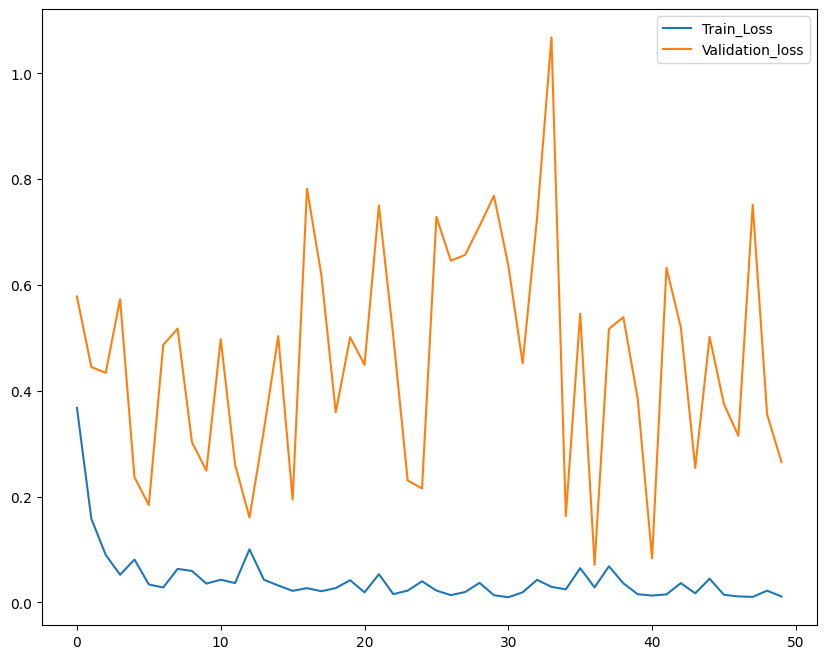

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history['loss'], label='Train_Loss')
plt.plot(hist.history['val_loss'], label='Validation_loss')
plt.legend()
plt.show()

In [12]:
from IPython.display import display, Image, clear_output

def video_show(frame, width=400):
    _, buffer = cv2.imencode(".jpg", frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=width))

model = load_model('faa.keras')

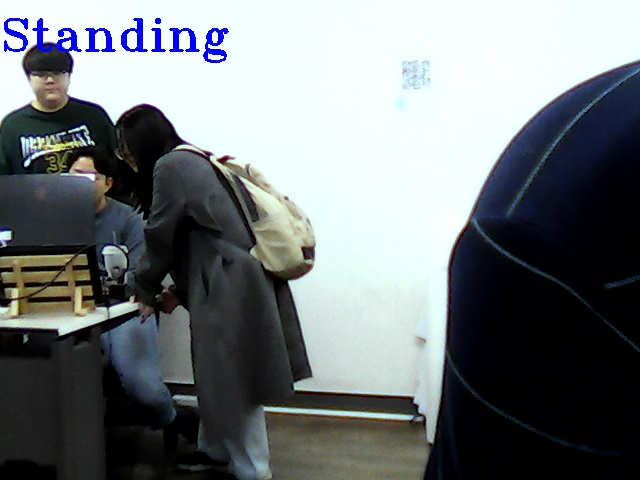

KeyboardInterrupt: 

In [17]:
path = "/home/shin/addinedu/project/DL_ML/data/archive (2)/Wrong sequence/23.mp4"
cap = cv2.VideoCapture(-1)

mp_pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
sequence = []
if cap.isOpened():
    while True:
        ret, frame = cap.read()
        if ret:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (640, 640))

            results = mp_pose.process(image)

            if results.pose_landmarks is None: continue
            
            sequence.append(extract_pose_landmarks(results))

            if len(sequence) == 10:
                data = np.array(sequence).reshape(1, 10, 36)

                predict = model.predict(data)
                predict_class = np.argmax(predict, axis=1)

                if predict_class == 0:
                    label = "Pushup"
                elif predict_class == 1:
                    label = "Standing"
                elif predict_class == 2:
                    label = "Staning Knee Raise"

                cv2.putText(frame, label, (0, 50), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (255, 0, 0), 2)

                sequence = sequence[1:]

            video_show(frame, 640)
        else:
            break

    cap.release()
    cv2.destroyAllWindows()